In [1]:
import sys
import os
import time
import matplotlib.pyplot as plt
sys.path.append(".")
sys.path.append("..")

from algorithms.old_path_planning import OldPathPlanner
from algorithms.path_planning import PathPlanner, stanley_smooth_path
from algorithms.optimized_path_planning import stanley_smooth_path as optimized_smooth_path
from algorithms.david_planning import torch_smooth, PathPlanner as DavidPathPlanning, stanley_smooth_path as david_smooth

from tvojemama.logger import LogReader

import torch
from torch import optim

%load_ext autoreload
%autoreload 2
%matplotlib inline

## Gather data from log

In [2]:
log_path = "/home/snake/eforce/bros/data/bros_logs/05_05_2023-07_09_13/AS/mission_05_05_2023-07_09_13.pkl"
log_reader = LogReader(log_path)

1076.087575196 1076.100148199


In [3]:
period = 0.05 # time between percep_data samples in seconds

percep_datas = []

counter = 0
start_time = None
for msg_t, (msg_name, data) in log_reader:
    
    mission_kwargs = data['mission_kwargs']
    percep_data = mission_kwargs['percep_data']
    
    if start_time is None:
        start_time = msg_t
        
    curr_msg_t = msg_t - start_time
        
    if curr_msg_t / period >= counter:
        counter += 1
        
        if percep_data.shape[0] != 0:
            percep_datas.append(percep_data)
    
print(f"got {len(percep_datas)} samples")

got 945 samples


## Run tests

In [4]:
def benchmark_path_planning(find_path_fn, smooth_fn=None):
    indiv_times = []
    start_time = time.time()
    for percep_data in percep_datas:
        curr_start_time = time.time()
        path = find_path_fn(percep_data)
        
        if smooth_fn is not None:
            path = smooth_fn(path)
            
        curr_end_time = time.time()
        indiv_times.append(curr_end_time - curr_start_time)
    end_time = time.time()
    
    print(f"took {end_time - start_time:.2f} seconds")
    print(f"\tMean time: {((end_time - start_time) / len(percep_datas) * 1000):.3f} ms")
    print(f"\tMax time: {max(indiv_times) * 1000:.3f} ms")
    print(f"\tMin time: {min(indiv_times) * 1000:.3f} ms")

In [5]:
# initializing
path_planner = PathPlanner()
old_path_planner = OldPathPlanner({"n_steps": 20})
david_planner = DavidPathPlanning()

In [6]:
benchmark_path_planning(find_path_fn=path_planner.find_path, smooth_fn=stanley_smooth_path)

took 10.37 seconds
	Mean time: 10.973 ms
	Max time: 27.184 ms
	Min time: 3.170 ms


In [7]:
benchmark_path_planning(find_path_fn=path_planner.find_path, smooth_fn=None)

took 4.90 seconds
	Mean time: 5.182 ms
	Max time: 18.652 ms
	Min time: 0.683 ms


In [8]:
benchmark_path_planning(find_path_fn=old_path_planner.find_path, smooth_fn=None)

took 0.85 seconds
	Mean time: 0.898 ms
	Max time: 4.185 ms
	Min time: 0.153 ms


In [9]:
benchmark_path_planning(find_path_fn=old_path_planner.find_path, smooth_fn=optimized_smooth_path)

took 5.90 seconds
	Mean time: 6.248 ms
	Max time: 54.897 ms
	Min time: 2.101 ms


In [10]:
benchmark_path_planning(find_path_fn=david_planner.find_path, smooth_fn=david_smooth)

took 5.28 seconds
	Mean time: 5.583 ms
	Max time: 11.555 ms
	Min time: 2.438 ms


In [11]:
benchmark_path_planning(find_path_fn=david_planner.find_path, smooth_fn=None)

took 0.63 seconds
	Mean time: 0.671 ms
	Max time: 1.710 ms
	Min time: 0.257 ms


## Custom solution

In [21]:
cones = percep_datas[310]
path = david_planner.find_path(cones)
smoother_path = torch_smooth(path)
# smoother_path = david_smooth(path)

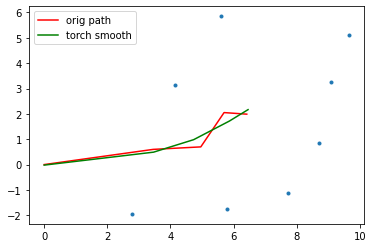

In [22]:
plt.plot(cones[:,0], cones[:,1], '.')
plt.plot(path[:,0], path[:,1], '-', color='red' ,label='orig path')
plt.plot(smoother_path[:,0], smoother_path[:,1], '-', color='green', label='torch smooth')
plt.legend()
plt.show()

In [20]:
benchmark_path_planning(find_path_fn=david_planner.find_path, smooth_fn=torch_smooth)

took 2.51 seconds
	Mean time: 2.657 ms
	Max time: 5.046 ms
	Min time: 2.110 ms
